# Analyze Synaptic Locations in Martinotti and Basket Cells

In [2]:
import sys, os

import pandas
import numpy as np
from scipy import stats

# packages from Allen Institute:
from meshparty import meshwork # version 1.16.14 (install with "pip install meshparty==1.16.14")
import pcg_skel # version 0.3.0 (install with "pip install meshparty==0.3.0")

sys.path.append('..')
import plot_tools as pt
import matplotlib.pylab as plt

# (optional) we disable numpy warning -- the RuntimeWarning that comes with np.nanmean 
import warnings
warnings.filterwarnings("ignore")

# color code:
colors = {'BC':'tab:red', 'MC':'tab:orange'}

## 1) Load and build dataset

In [3]:
datafolder = '../data/SchneiderMizell_et_al_2023'
DATASET = {}

for key in os.listdir(datafolder):
    if 'csv' in key:
        DATASET[key.replace('.csv', '')] = pandas.read_csv('../data/SchneiderMizell_et_al_2023/%s' % key, encoding='utf-8')
        
# ID of the two cell types of interest:
for cType in ['MC', 'BC']:
    DATASET['%s_id' % cType] = DATASET['cell_types']['pt_root_id'][\
                                    DATASET['cell_types']['cell_type_manual']==cType]

## 2) Analyze presynaptic locations

In [4]:
def load_cell(ID):
    """
    we translate everything in terms of skeleton indices ! (mesh properties)
        we copy this function to 
    """
    nrn = meshwork.load_meshwork(os.path.join(datafolder, 'skeletons', 'meshwork', '%s.h5'%ID))
    nrn.root_id = ID

    # 1) splitting axon and dendrites !
    axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(nrn, 
                                                                pre_anno='pre_syn',
                                                                post_anno='post_syn')
    if Q>0.5:
        nrn.axon_inds = nrn.skeleton.mesh_to_skel_map[axon_inds]
        nrn.is_axon = np.array([(m in nrn.axon_inds) for m in nrn.skeleton_indices], dtype=bool)
        # dendritic cover paths
        nrn.dend_cover_paths = []
        for cover_path in nrn.skeleton.cover_paths:
            path = [c for c in cover_path if c not in nrn.axon_inds]
            if len(path)>0:
                nrn.dend_cover_paths.append(path)
    else:
        print('axon splitting not trusted...')
        
    # 2) get synapses:
    nrn.post_syn_sites = nrn.skeleton.mesh_to_skel_map[nrn.anno['post_syn']['mesh_ind']]
    
    # 3) check that the synapses do belong to the dendrite !
    syn_in_dend_cond = np.array([(i not in nrn.skeleton_indices[nrn.is_axon]) for i in nrn.post_syn_sites])
    nrn.fraction_synapses_excluded = np.sum(~syn_in_dend_cond)/len(nrn.post_syn_sites)
    # and restrict to those
    nrn.post_syn_sites = nrn.post_syn_sites[syn_in_dend_cond]
    
    # 4) compute the path distance to soma
    nrn.syn_dist_to_soma = [nrn.skeleton.distance_to_root[p]/1_000 for p in nrn.post_syn_sites]
    
    return nrn

for cType in ['MC', 'BC']:
    DATASET[cType+'_nrn'] = []
    DATASET[cType+'_fraction_synapses_excluded'] = []
    for i, ID in enumerate(DATASET['%s_id' % cType]):
        DATASET[cType+'_nrn'].append(load_cell(ID))

In [5]:
# add example cells
DATASET['example_cell_ID_BC'] = 16
DATASET['example_cell_ID_MC'] = 7

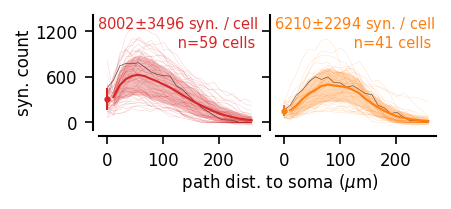

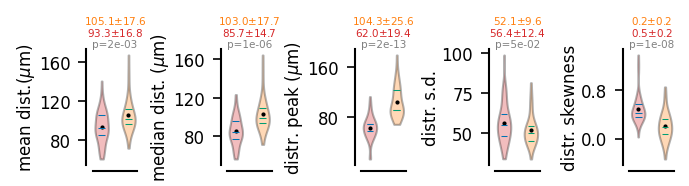

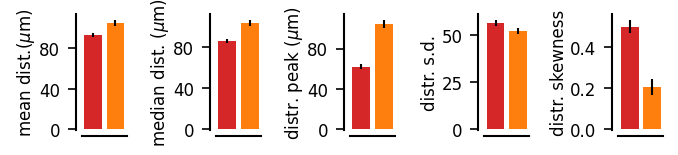

In [15]:
fig1, AX = plt.subplots(1, 2, figsize=(2.9,1))
plt.subplots_adjust(wspace=0.1)

fig2, AX2= plt.subplots(1, 5, figsize=(5,1))
plt.subplots_adjust(wspace=2)

fig3, AX3= plt.subplots(1, 5, figsize=(5,1))
plt.subplots_adjust(wspace=2)


x = np.linspace(0, 270, 25)

def peak_func(values, x=x):
    hist, _ = np.histogram(values, bins=x)
    return x[1:][np.argmax(hist)]

for c, ax, cType in zip(range(2), AX, ['BC', 'MC']):
    HIST, NSYNS = [] ,[]
    for i, nrn in enumerate(DATASET['%s_nrn' % cType]):
        hist, _ = np.histogram(nrn.syn_dist_to_soma, bins=x, density=False)
        if i==DATASET['example_cell_ID_%s' % cType]:
            ax.plot(x[:-1], hist, lw=0.2, color='k')
        else:
            ax.plot(x[:-1], hist, lw=0.05, color=colors[cType])
        HIST.append(hist)
        NSYNS.append(len(nrn.post_syn_sites))
    
    pt.plot(x[1:-1], np.mean(HIST, axis=0)[1:], sy=np.std(HIST, axis=0)[1:], ax=ax, color=colors[cType])
    pt.scatter([0], [np.mean(HIST, axis=0)[0]], sy=[np.std(HIST, axis=0)[0]], ax=ax, color=colors[cType], ms=2)
    pt.annotate(ax, '%i$\pm$%i syn. / cell \n n=%i cells ' % (np.mean(NSYNS),
                                                              np.std(NSYNS),
                                                             len(DATASET[cType+'_id'])), 
                (1,1), ha='right', va='top', fontsize=7, color=colors[cType])
    
for ax, ax3, func, label in zip(AX2, AX3, 
                           [np.mean, np.median, peak_func, np.std, stats.skew],
                           ['mean dist.($\mu$m)', 'median dist. ($\mu$m)',
                            'distr. peak ($\mu$m)', 'distr. s.d.', 'distr. skewness']):
    
    for c, cType in zip(range(2), ['BC', 'MC']):
        values = [func(nrn.syn_dist_to_soma) for nrn in DATASET['%s_nrn' % cType]]
        ax3.bar([c], [np.mean(values)], yerr=[stats.sem(values)], color=colors[cType])
        pt.violin(values, X=[c], COLORS=[colors[cType]], ax=ax)
        pt.annotate(ax, '%.1f$\pm$%.1f' % (np.mean(values), np.std(values)) + (1+c)*'\n', 
                    (0.5,1), ha='center', fontsize=5, color=colors[cType])
    pt.annotate(ax, 'p=%.0e' % stats.mannwhitneyu(*[\
                                                   [func(nrn.syn_dist_to_soma) for nrn in DATASET['%s_nrn' % cType]]\
                                                   for cType in ['BC', 'MC']]).pvalue, 
                    (0.5,1), ha='center', fontsize=5, color='grey')
        
    pt.set_plot(ax, ylabel=label, xticks=[])
    pt.set_plot(ax3, ylabel=label, xticks=[])
    
pt.set_plot(AX[0], xticks=np.arange(3)*100, 
            ylabel='syn. count', xlabel=38*' '+'path dist. to soma ($\mu$m)')
pt.set_plot(AX[1], yticks_labels=[], xticks=np.arange(3)*100)

pt.set_common_ylims(AX)
#fig1.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig1.svg'))
#fig2.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig2.svg'))

## Linear Density

synapses counted: 6952/6966


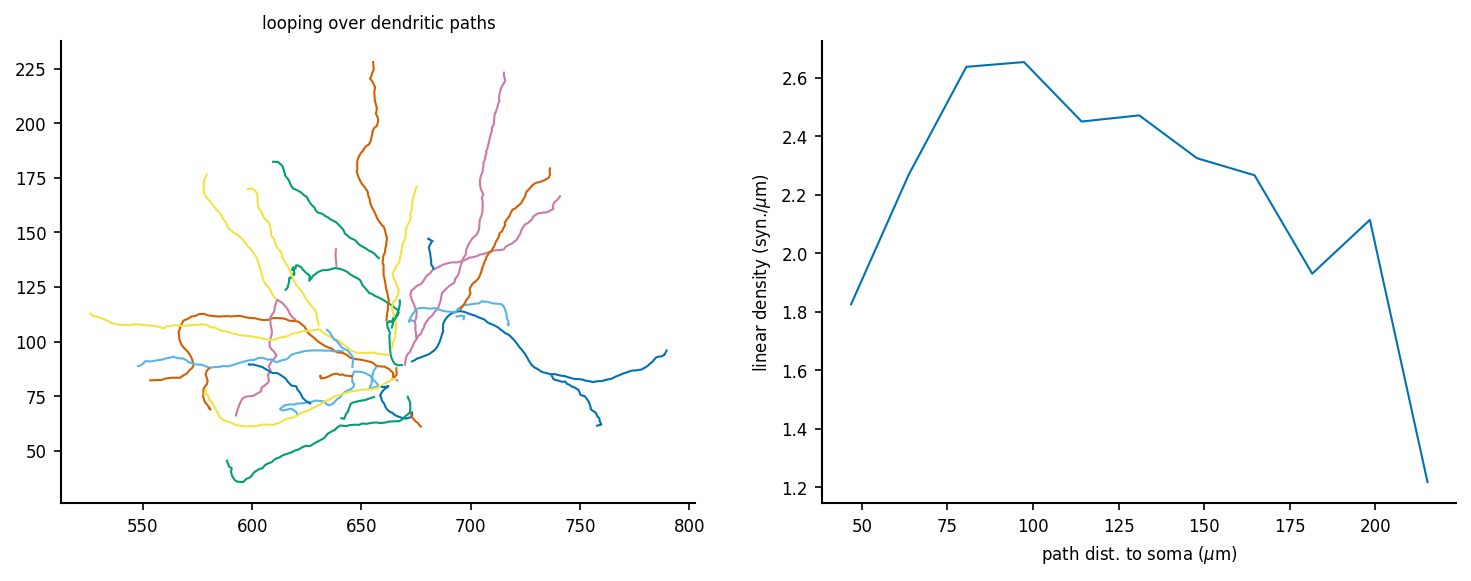

In [7]:
def compute_single_cell(nrn, 
                        bins = np.linspace(30, 350, 20),
                        verbose=True, with_fig=False):
    
    if with_fig:
        fig, AX = plt.subplots(1, 2, figsize=(12,4))

    DENSITY_HIST, Ntot_syn = [], 0

    for i, path in enumerate(nrn.dend_cover_paths):
        
        # we plot all paths with a different color
        if with_fig:
            AX[0].plot(nrn.skeleton.vertices[path,0]/1e3, 
                       nrn.skeleton.vertices[path,1]/1e3)
    
        path_to_soma = [nrn.skeleton.distance_to_root[p]/1_000 for p in path]

        count_along_path = np.zeros(len(path))
        for i, p in enumerate(path):
            count_along_path[i] = np.sum(nrn.post_syn_sites==p)

        binned_dist = np.digitize(path_to_soma, bins=bins)
        density_hist = np.ones(len(bins))*np.nan # nan by default
        for b in range(1, len(bins)-1):
            if np.sum(binned_dist==b)>1:
                # we sum all synapses that fall into this bin and we divide by the bin length
                density_hist[b] = np.sum(count_along_path[binned_dist==b])/(bins[1]-bins[0])

        DENSITY_HIST.append(density_hist)
        Ntot_syn += count_along_path.sum()
    
    # add
    nrn.linear_density = np.nanmean(DENSITY_HIST, axis=0)
    nrn.linear_density_bins = bins
    
    if verbose:
        print('synapses counted: %i/%i' % (Ntot_syn, len(nrn.anno['post_syn']['mesh_ind'])))

    if with_fig:
        AX[1].plot(bins[1:], np.nanmean(DENSITY_HIST, axis=0)[1:]) # only non-infinite values contributing

        AX[0].set_title('looping over dendritic paths')
        AX[0].axis('equal')
        
        AX[1].set_xlabel('path dist. to soma ($\mu$m)');
        AX[1].set_ylabel('linear density (syn./$\mu$m)')
    else:
        fig = None
        
compute_single_cell(DATASET['MC_nrn'][18], with_fig=True)

## Compute linear density along the tree after binning the distance to soma

In [8]:
bins = np.linspace(20, 290, 18) # BINNING (tradeoff between good resolution and not too noisy points)
for c, ax, cType in zip(range(2), AX, ['MC', 'BC']):
    for i, nrn in enumerate(DATASET['%s_nrn' % cType]):
        compute_single_cell(nrn, bins=bins, verbose=False)

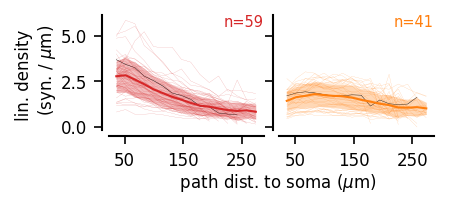

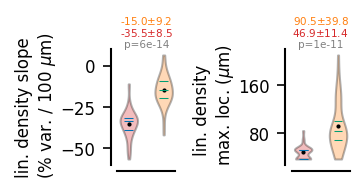

In [10]:
fig1, AX = plt.subplots(1, 2, figsize=(2.8,1))
plt.subplots_adjust(wspace=0.1)
fig2, AX2= plt.subplots(1, 2, figsize=(2,1))
plt.subplots_adjust(wspace=2)

for c, ax, cType in zip(range(2), AX, ['BC', 'MC']):
    HIST, SLOPES = [], []
    DATASET['lin_density_slopes_%s' % cType] = []
    DATASET['lin_density_max_%s' % cType] = []
    for i, nrn in enumerate(DATASET['%s_nrn' % cType]):
        if i==DATASET['example_cell_ID_%s' % cType]:
            ax.plot(nrn.linear_density_bins, nrn.linear_density, lw=0.2, color='k')
        else:
            ax.plot(nrn.linear_density_bins, nrn.linear_density, lw=0.05, color=colors[cType])
        HIST.append(nrn.linear_density)
        # now slopes
        cond = np.isfinite(nrn.linear_density)
        pol = np.polyfit(nrn.linear_density_bins[cond],
                         100*nrn.linear_density[cond]/np.max(nrn.linear_density[cond]), 1)
        DATASET['lin_density_slopes_%s' % cType].append(100.*pol[0])
        imax = np.argmax(nrn.linear_density[cond][:-2]) # find the max of the curves
        DATASET['lin_density_max_%s' % cType].append(nrn.linear_density_bins[cond][:-2][imax])
        
    pt.plot(bins, np.nanmean(HIST, axis=0), sy=np.nanstd(HIST, axis=0), ax=ax, color=colors[cType])
    pt.annotate(ax, 'n=%i' % len(HIST), (1,1), va='top', ha='right', color=colors[cType], fontsize=7)
    
for ax, key, label in zip(AX2,
                           ['lin_density_slopes_%s', 'lin_density_max_%s'],
                           ['lin. density slope\n (% var. / 100 $\mu$m)',
                            'lin. density \n max. loc. ($\mu$m)']):
    
    for c, cType in zip(range(2), ['BC', 'MC']):
        pt.violin(DATASET[key % cType], X=[c], COLORS=[colors[cType]], ax=ax)
        pt.annotate(ax, '%.1f$\pm$%.1f' % (np.mean(DATASET[key % cType]), np.std(DATASET[key % cType])) + (1+c)*'\n', 
                    (0.5,1), ha='center', fontsize=5, color=colors[cType])
    pt.annotate(ax, 'p=%.0e' % stats.mannwhitneyu(*[DATASET[key % cType] for cType in ['BC', 'MC']]).pvalue, 
                    (0.5,1), ha='center', fontsize=5, color='grey')
        
    pt.set_plot(ax, ylabel=label, xticks=[])
    
pt.set_plot(AX[0], xticks=50+np.arange(3)*100,
            ylabel='lin. density \n (syn. / $\mu$m)', xlabel=35*' '+'path dist. to soma ($\mu$m)')
pt.set_plot(AX[1], xticks=50+np.arange(3)*100, yticks_labels=[])
pt.set_common_ylims(AX)

#fig1.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig1.svg'))
#fig2.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig2.svg'))

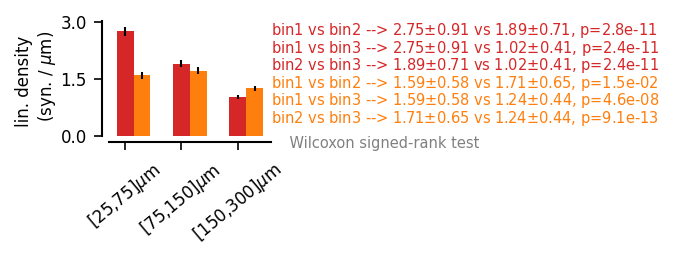

In [11]:
BINS = np.array([25, 75, 150, 300])

from itertools import product

fig1, ax = plt.subplots(1, figsize=(1.4,1))

VALUES = {}
for c, cType in zip(range(2), ['BC', 'MC']):
    VALUES[cType] = []
    for k, (x1, x2) in enumerate(zip(BINS[:-1], BINS[1:])):
        values = []
        for i, nrn in enumerate(DATASET['%s_nrn' % cType]):
            cond = (nrn.linear_density_bins>=x1) & (nrn.linear_density_bins<x2)
            values.append(np.nanmean(nrn.linear_density[cond]))
        #ax.bar([k+c*0.3], [np.mean(values)], yerr=[stats.sem(values)], color=colors[cType], width=0.3)
        ax.bar([k+c*0.3], [np.mean(values)], yerr=[stats.sem(values)], color=colors[cType], width=0.3)
        VALUES[cType].append(values)
        
# statistical analysis : paired comparison --> wilcoxon
ax.annotate('    Wilcoxon signed-rank test',
            (1, -0.1), color='grey', xycoords='axes fraction', fontsize=7)

i=0
for c, cType in zip(range(2), ['BC', 'MC']):
    for i1, i2 in product(range(3), range(3)):
        if i2>i1:
            ax.annotate(i*'\n'+'bin%i vs bin%i --> %.2f$\pm$%.2f vs %.2f$\pm$%.2f, p=%.1e' % (i1+1, i2+1, \
                                            np.mean(VALUES[cType][i1]), np.std(VALUES[cType][i1]),
                                            np.mean(VALUES[cType][i2]), np.std(VALUES[cType][i2]),
                              stats.wilcoxon(VALUES[cType][i1], VALUES[cType][i2]).pvalue),
                        (1,1), color=colors[cType], va='top', xycoords='axes fraction', fontsize=7)
            
            i+=1
    
XTICKS = ['[%i,%i]$\mu$m ' % (x1, x2) for x1, x2 in zip(BINS[:-1], BINS[1:])]
pt.set_plot(ax, ylabel='lin. density \n (syn. / $\mu$m)',
            xticks=range(3), xticks_labels=XTICKS, xticks_rotation=40)

### Get the positions of the example `root_ID` to find them in neuroglancer

In [ ]:
#ID = np.array(DATASET['MC_id'])[DATASET['example_cell_ID_MC']]
ID = np.array(DATASET['BC_id'])[DATASET['example_cell_ID_BC']]
import pandas
em_data = pandas.read_csv('../data/em_connectomics_mesh_skeletons_directory_proof_status.csv')
em_data['pt_position'][em_data['root_id']==ID]

## Checking diversity of Martinotti Cells across Layers (Supp. Fig.)

In [13]:
# Manual classification of Layer 2/3 and Layer 5 cells based on locations and axonal projections
Layer23_MC_indices = np.array([4, 9, 11, 14, 16, 18, 19, 20, 21, 25, 29, 30, 32, 34])
Layer5_MC_indices = np.array([i for i in range(len(DATASET['MC_nrn'])) if i not in Layer23_MC_indices])

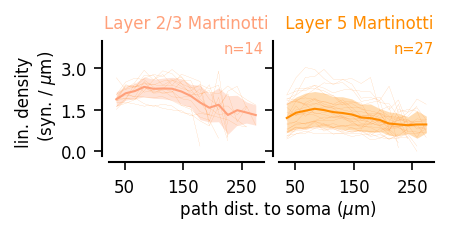

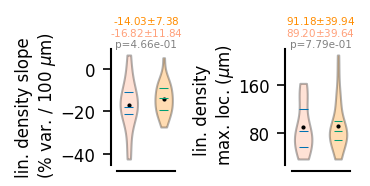

In [14]:
fig1, AX = plt.subplots(1, 2, figsize=(2.8,1))
plt.subplots_adjust(wspace=0.1)
fig2, AX2= plt.subplots(1, 2, figsize=(2,1))
plt.subplots_adjust(wspace=2)

COLORS = ['lightsalmon', 'darkorange'] # [Layer 2/3, Layer 5]

for c, ax, indices, label in zip(range(2), AX, 
                                 [Layer23_MC_indices, Layer5_MC_indices],
                                 ['Layer 2/3', ' Layer 5']):
    HIST, SLOPES = [], []
    DATASET['lin_density_slopes_MC_%s' % label] = []
    DATASET['lin_density_max_MC_%s' % label] = []
    for i in indices:
        nrn = DATASET['%s_nrn' % cType][i]
        ax.plot(nrn.linear_density_bins, nrn.linear_density, lw=0.05, color=colors[cType])
        HIST.append(nrn.linear_density)
        # now slopes
        cond = np.isfinite(nrn.linear_density)
        pol = np.polyfit(nrn.linear_density_bins[cond],
                         100*nrn.linear_density[cond]/np.max(nrn.linear_density[cond]), 1)
        DATASET['lin_density_slopes_MC_%s' % label].append(100.*pol[0])
        imax = np.argmax(nrn.linear_density[cond][:-2]) # find the max of the curves
        DATASET['lin_density_max_MC_%s' % label].append(nrn.linear_density_bins[cond][:-2][imax])
        
    pt.plot(bins, np.nanmean(HIST, axis=0), sy=np.nanstd(HIST, axis=0), ax=ax, color=COLORS[c])
    pt.annotate(ax, 'n=%i' % len(HIST), (1,1), va='top', ha='right', color=COLORS[c], fontsize=7)
    ax.set_title('%s Martinotti' % label, color=COLORS[c])
    
for ax, key, label in zip(AX2,
                           ['lin_density_slopes_MC_%s', 'lin_density_max_MC_%s'],
                           ['lin. density slope\n (% var. / 100 $\mu$m)',
                            'lin. density \n max. loc. ($\mu$m)']):
    
    for c, layer in zip(range(2), ['Layer 2/3', ' Layer 5'], ):
        pt.violin(DATASET[key % layer], X=[c], COLORS=[COLORS[c]], ax=ax)
        pt.annotate(ax, '%.2f$\pm$%.2f' % (np.mean(DATASET[key % layer]), np.std(DATASET[key % layer])) + (1+c)*'\n', 
                    (0.5,1), ha='center', fontsize=5, color=COLORS[c])
    pt.annotate(ax, 'p=%.2e' % stats.mannwhitneyu(*[DATASET[key % layer] for layer in ['Layer 2/3', ' Layer 5']]).pvalue, 
                    (0.5,1), ha='center', fontsize=5, color='grey')
        
    pt.set_plot(ax, ylabel=label, xticks=[])
    
pt.set_plot(AX[0], xticks=50+np.arange(3)*100, ylim=[0,4],
            ylabel='lin. density \n (syn. / $\mu$m)', xlabel=35*' '+'path dist. to soma ($\mu$m)')
pt.set_plot(AX[1], xticks=50+np.arange(3)*100, yticks_labels=[])
pt.set_common_ylims(AX)